# Problem description

Plot energy profiles of reco and sim tracksters

In [5]:
import uproot
import awkward as ak
import numpy as np

import matplotlib.pyplot as plt

from reco.plotting import plot_event, plot_tracksters
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map, get_bary, get_lc
from reco.matching import get_highest_energy_fraction_simtracksters

# %matplotlib widget
%matplotlib inline

data_root = "data"
ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"
plt.style.use('seaborn-whitegrid')

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

E_TH = 3

In [6]:
eid = 0

# get layercluster layers and energy
e_lc = tracksters["vertices_energy"].array()[eid]
z_lc = tracksters["vertices_z"].array()[eid]

# get layercluster layers and energy
sim_e_lc = simtracksters["stsSC_vertices_energy"].array()[eid]
sim_z_lc = simtracksters["stsSC_vertices_z"].array()[eid]

raw_e = tracksters["raw_energy"].array()[eid]
large_tracksters = np.where(raw_e > 0)[0]
print("large tracksters:", large_tracksters)

large tracksters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]


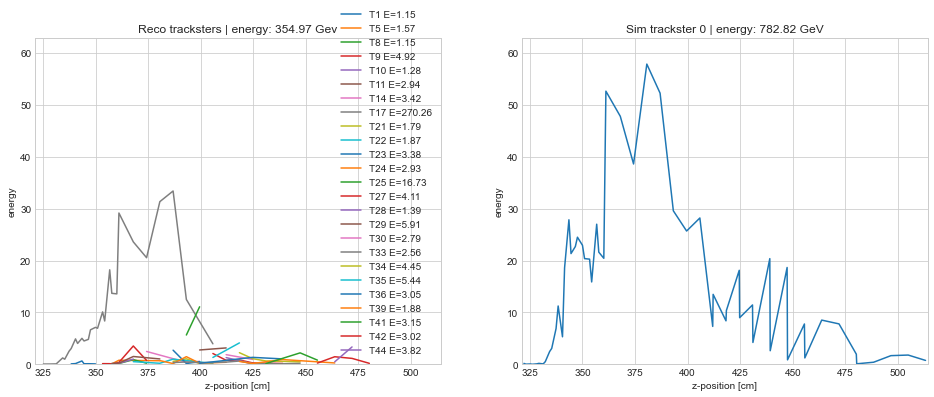

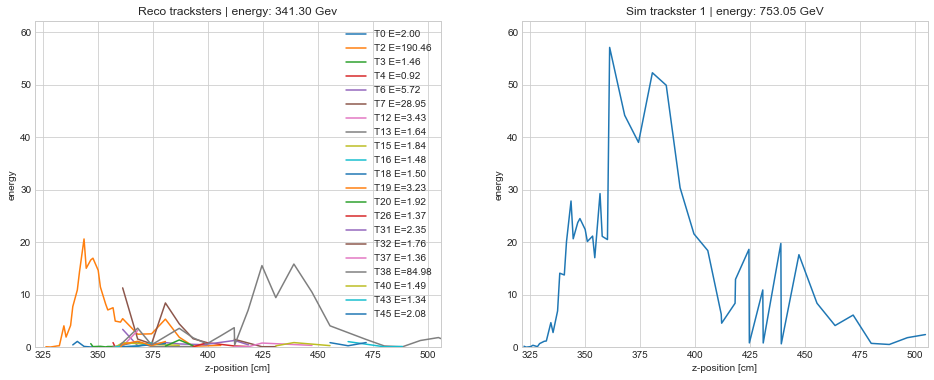

In [7]:
# pick a trackster

ntx = len(sim_e_lc)

axs = []
rec_e = [0]*ntx

for i in range(ntx):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ste = sim_e_lc[i]
    stz = sim_z_lc[i]

    st_agg = {}
    for e, z in zip(ste, stz):
        if z in st_agg:
            st_agg[z] += e
        else:
            st_agg[z] = e
    
    st_arr = np.array(sorted(st_agg.items()))

    xmin = st_arr[0, 0] - 1
    xmax = st_arr[-1, 0] + 1
    ymax = max(st_arr[:, 1]) + 5
    
    ax1.set_title(f"Reco tracksters above {E_TH} GeV")
    ax1.set_xlabel("z-position [cm]")
    ax1.set_ylabel("energy")
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(0, ymax)

    ax2.set_title(f"Sim trackster {i} | energy: {sum(ste):.2f} GeV")
    ax2.plot(st_arr[:,0], st_arr[:,1])
    ax2.set_xlabel("z-position [cm]")
    ax2.set_ylabel("energy")
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(0, ymax)

    axs.append(ax1)

_, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)

for id in large_tracksters:
    te = e_lc[id]
    tz = z_lc[id]

    # aggregate per layer
    t_agg = {}
    for e, z in zip(te, tz):
        if z in t_agg:
            t_agg[z] += e
        else:
            t_agg[z] = e

    stid = reco_st[id]
    ax = axs[stid]

    t_arr = np.array(sorted(t_agg.items()))
    ax.plot(t_arr[:,0], t_arr[:,1], label=f"T{id} E={sum(te):.2f}")

    rec_e[stid] += sum(te)
    ax.set_title(f"Reco tracksters | energy: {rec_e[stid]:.2f} Gev")

    ax.legend()

plt.show()